## Model 1. Logistic Regression

#### Without hyperparametrics tunning

In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score, f1_score, recall_score, precision_score, roc_auc_score,roc_curve


In [2]:
with open('Dataset_After_Preprocessing.pkl', 'rb') as f:
    Dataset_After_Preprocessing = pickle.load(f)

In [3]:

# Memisahkan fitur dan target
X = Dataset_After_Preprocessing.drop(columns=['Exited'])
y = Dataset_After_Preprocessing['Exited']

# Membagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train is:", X_train.shape)
print("Shape of X_test is:", X_test.shape)
print("Shape of y_train is:", y_train.shape)
print("Shape of y_test is:", y_test.shape)

# Mengubah tipe data target menjadi integer
y_train = y_train.astype('int')
y_test = y_test.astype('int')


Shape of X_train is: (12545, 11)
Shape of X_test is: (3137, 11)
Shape of y_train is: (12545,)
Shape of y_test is: (3137,)


In [4]:

# Melatih model Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Melakukan prediksi pada data training dan testing
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

### Metric Evaluation

####  Accuracy, Precision, Recall, dan F1

In [5]:

# Menghitung dan mencetak metrik evaluasi
acc_train_l = round(accuracy_score(y_train, y_train_pred) * 100, 2)
acc_test_l = round(accuracy_score(y_test, y_test_pred) * 100, 2)
f1_l = round(f1_score(y_test, y_test_pred, average="micro") * 100, 2)
recall_l = round(recall_score(y_test, y_test_pred, average="micro") * 100, 2)
precision_l = round(precision_score(y_test, y_test_pred, average="micro") * 100, 2)

# Menghitung ROC AUC
y_score_l = logreg.predict_proba(X_test)[:,1] # Menggunakan probabilitas kelas positif
roc_auc_l = roc_auc_score(y_test, y_score_l)

# Cross-validation
cv_scores_l = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')

In [6]:
print("__________________________________Hasil Evaluasi Model Logistic Regression_________________________________________________")
print("Accuracy Score of Model on Training Data is =>",acc_train_l,"%")
print("Accuracy Score of Model on Testing Data  is =>",acc_test_l,"%")
print("F1 Score of the Model is =>",f1_l)
print("Recall Score of the Model is =>",recall_l)
print("Precision Score of the Model is =>",precision_l)
print("ROC AUC Score of the Model is =>", roc_auc_l)
print("Cross-validation Accuracy Scores:", cv_scores_l)
print("Mean Cross-validation Accuracy:", cv_scores_l.mean())
print("___________________________________________________________________________________")

Accuracy Score of Model on Training Data is => 76.44 %
Accuracy Score of Model on Testing Data  is => 74.78 %
F1 Score of the Model is => 74.78
Recall Score of the Model is => 74.78
Precision Score of the Model is => 74.78
ROC AUC Score of the Model is => 0.8336571802553647
Cross-validation Accuracy Scores: [0.7712236  0.77202073 0.75408529 0.77401355 0.75687525]
Mean Cross-validation Accuracy: 0.7656436827421284


- Kita dapat mengamati bahwa recall, precision, dan F1 Score semuanya sama, artinya model kita mencapai keseimbangan sempurna antara mengidentifikasi sampel positif (recall) dengan benar dan meminimalkan positif palsu (precision).
- Nilai untuk F1 score, Recall, dan Precision semuanya kurang lebih 0,7. Sehingga metric ini menunjukkan bahwa model tersebut mencapai akurasi yang baik dalam memprediksi kelas positif.

####  Confussion Matrix and ROC

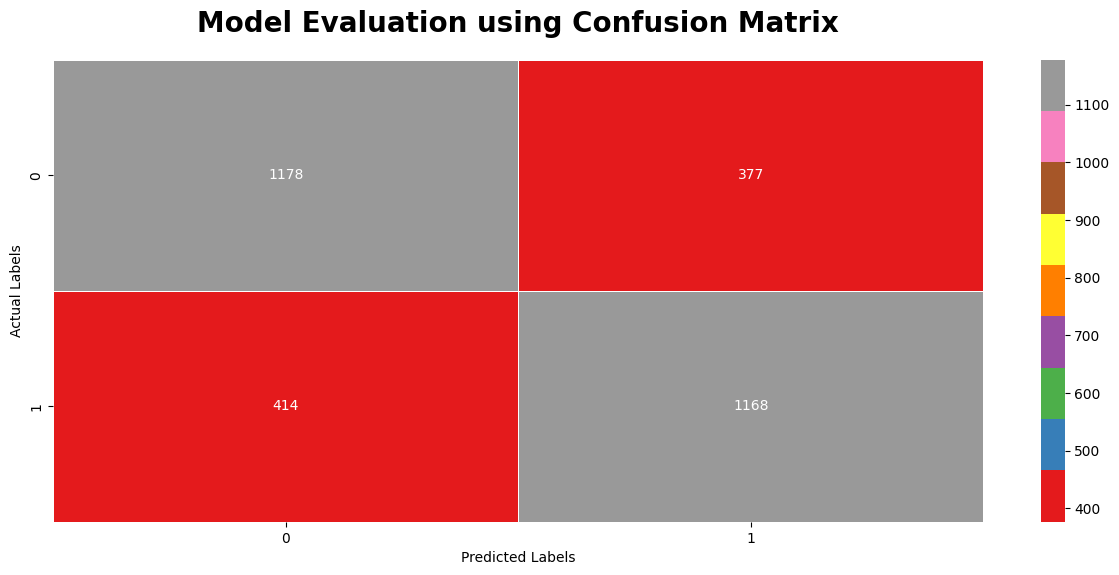

In [7]:
cm = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

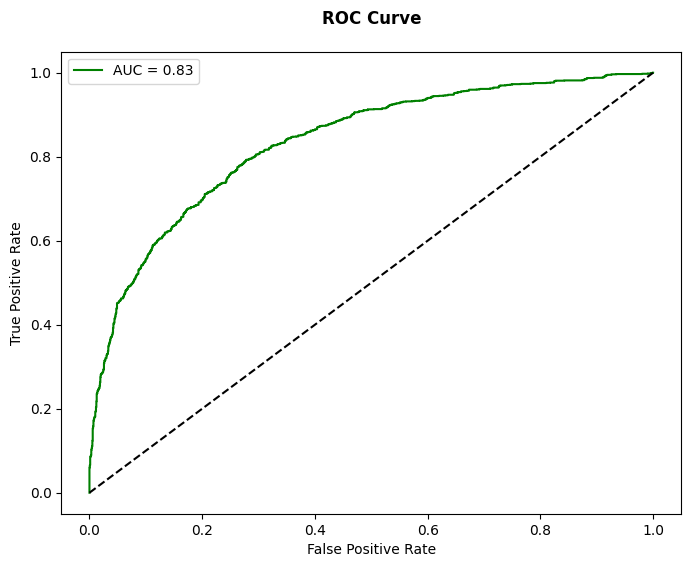

In [8]:
y_pred_proba = logreg.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

## Logistik Regression With Hyper parametrics tunning

Hyperparameter tuning diperlukan untuk:
- menemukan pengaturan optimal dari parameter eksternal dalam model machine learning,
- memastikan performa terbaik,
- mencegah overfitting atau underfitting,
- meningkatkan kemampuan model untuk menggeneralisasi pada data baru.

Pada tahap ini dipilih "Grid Search" karena dataset juga memiliki resource yang cukup baik, dan bisa diperoleh hyperparameter yang paling optimal

In [9]:
# melakukan Grid Search untuk menemukan parameter terbaik untuk model
logreg = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularisasi parameter, semakin kecil nilainya semakin kuat regularisasi
    'penalty': ['l1', 'l2'],          # Jenis regularisasi: L1 (Lasso) atau L2 (Ridge)
    'solver': ['liblinear', 'saga'],  # Solver yang cocok untuk regularisasi L1
    'class_weight': [None, 'balanced'], # Bobot kelas untuk menangani ketidakseimbangan kelas
    'max_iter': [100, 200, 300]       # Jumlah iterasi maksimum
}


grid_search = GridSearchCV(logreg, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train,y_train)


# mencari parameter terbaik untuk RandomForest
best_parameters = grid_search.best_params_

print("Parameter terbaik untuk RandomForest yaitu :\n\n")
print(best_parameters)

# membuat RandomForest dengan parameter terbaik
logregh = LogisticRegression(**best_parameters)

logregh.fit(X_train,y_train)

# menghitung akurasi model
y_train_pred = logregh.predict(X_train)
y_test_pred  = logregh.predict(X_test)


Parameter terbaik untuk RandomForest yaitu :


{'C': 10, 'class_weight': None, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}


### Metric Evaluation

####  Accuracy, Precision, Recall, dan F1

In [10]:
# Menghitung dan mencetak metrik evaluasi
acc_train_lh = round(accuracy_score(y_train, y_train_pred) * 100, 2)
acc_test_lh = round(accuracy_score(y_test, y_test_pred) * 100, 2)
f1_lh = round(f1_score(y_test, y_test_pred, average="micro") * 100, 2)
recall_lh = round(recall_score(y_test, y_test_pred, average="micro") * 100, 2)
precision_lh = round(precision_score(y_test, y_test_pred, average="micro") * 100, 2)

# Menghitung ROC AUC
y_score_lh = logreg.predict_proba(X_test)[:,1] # Menggunakan probabilitas kelas positif
roc_auc_lh = roc_auc_score(y_test, y_score_lh)

# Cross-validation
cv_scores_lh = cross_val_score(logregh, X_train, y_train, cv=5, scoring='accuracy')

In [11]:
print("__________________________________Hasil Evaluasi Model Logistic Regression Hyper Parametrics Tunning_________________________________________________")

print("Accuracy Score of Model on Training Data is =>",acc_train_lh,"%")
print("Accuracy Score of Model on Testing Data  is =>",acc_test_lh,"%")
print("F1 Score of the Model is =>",f1_lh)
print("Recall Score of the Model is =>",recall_lh)
print("Precision Score of the Model is =>",precision_lh)
print("ROC AUC Score of the Model is =>", roc_auc_lh)
print("Cross-validation Accuracy Scores:", cv_scores_lh)
print("Mean Cross-validation Accuracy:", cv_scores_lh.mean())

print("___________________________________________________________________________________")

Accuracy Score of Model on Training Data is => 76.52 %
Accuracy Score of Model on Testing Data  is => 74.91 %
F1 Score of the Model is => 74.91
Recall Score of the Model is => 74.91
Precision Score of the Model is => 74.91
ROC AUC Score of the Model is => 0.8336177495213434
Cross-validation Accuracy Scores: [0.77281786 0.77361499 0.75488242 0.77361499 0.75647668]
Mean Cross-validation Accuracy: 0.7662813870067755


- Kita dapat mengamati bahwa recall, precision, dan F1 Score semuanya sama, artinya model kita mencapai keseimbangan sempurna antara mengidentifikasi sampel positif (recall) dengan benar dan meminimalkan positif palsu (precision).
- Nilai untuk F1 score, Recall, dan Precision semuanya kurang lebih 0,7. Sehingga metric ini menunjukkan bahwa model tersebut mencapai akurasi yang baik dalam memprediksi kelas positif.

####  Confussion Matrix and ROC

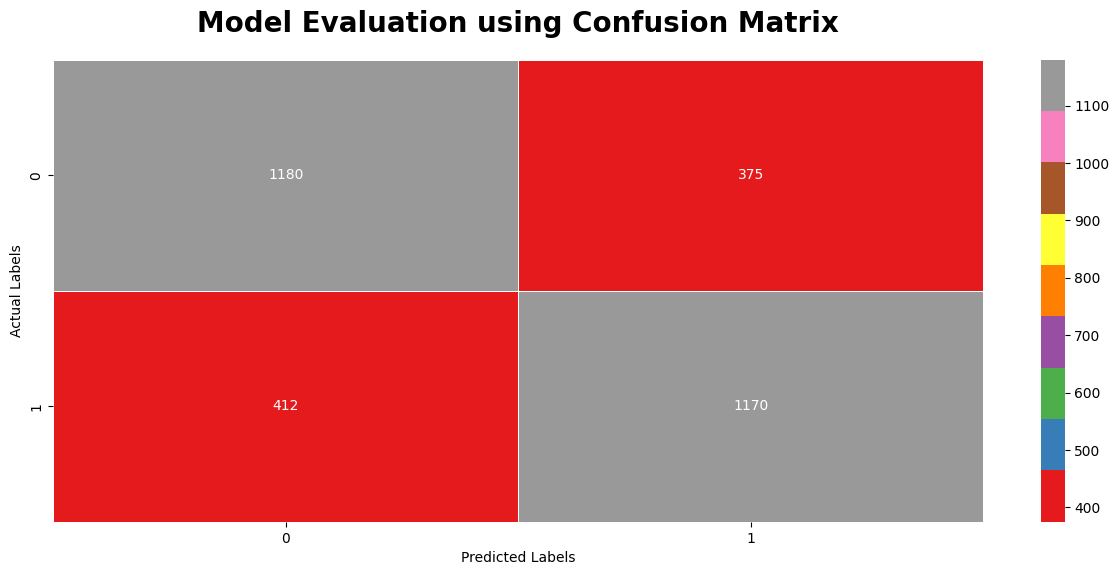

In [12]:
cm = confusion_matrix(y_test,y_test_pred)

plt.figure(figsize=(15,6))
sns.heatmap(data=cm, linewidth=.5, annot=True, fmt="g", cmap="Set1")
plt.title("Model Evaluation using Confusion Matrix",fontsize=20,pad=20,fontweight="black")
plt.ylabel("Actual Labels")
plt.xlabel("Predicted Labels")
plt.show()

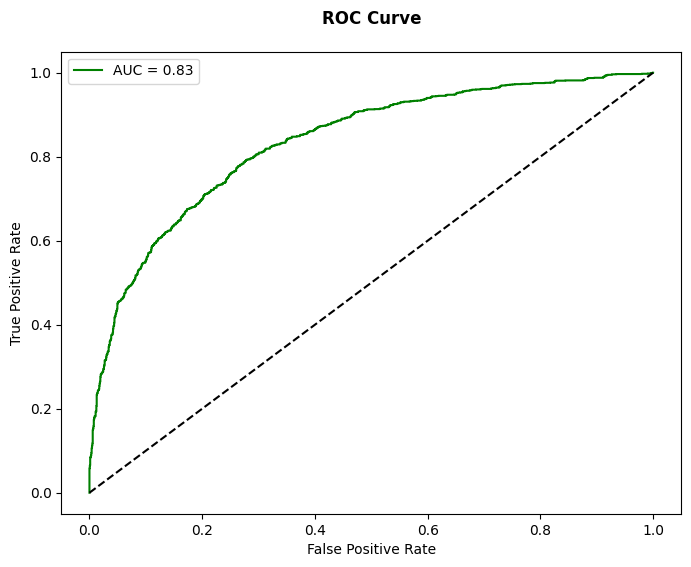

In [13]:
y_pred_proba = logreg.predict_proba(X_test)[:][:,1]

df_actual_predicted = pd.concat([pd.DataFrame(np.array(y_test), columns=["y_actual"])])
df_actual_predicted.index = y_test.index


fpr, tpr, thresholds = roc_curve(df_actual_predicted["y_actual"], y_pred_proba)
auc = roc_auc_score(df_actual_predicted["y_actual"], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}",color="green")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve",pad=20,fontweight="black")
plt.legend()
plt.show()

In [1]:
# Menyimpan variabel-variabel ke dalam dictionary
metrics_dict = {
    'logreg' : logreg,
    'logregh' : logregh,
    'acc_train_l': acc_train_l,
    'acc_test_l': acc_test_l,
    'f1_l': f1_l,
    'recall_l': recall_l,
    'precision_l': precision_l,
    'roc_auc_l': roc_auc_l,
    'cv_scores_l': cv_scores_l,
    'acc_train_lh': acc_train_lh,
    'acc_test_lh': acc_test_lh,
    'f1_lh': f1_lh,
    'recall_lh': recall_lh,
    'precision_lh': precision_lh,
    'roc_auc_lh': roc_auc_lh,
    'cv_scores_lh': cv_scores_lh
}

# Menyimpan dictionary ke dalam file pickle
with open('logisticregresionmetrics.pickle', 'wb') as f:
    pickle.dump(metrics_dict, f)

NameError: name 'logreg' is not defined